In [463]:
import pickle
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## Obtendo os dados e processando categóricas.

In [464]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/data


In [465]:
model_data = data.copy()

## Funções para análise de dados

In [466]:
def nonNull_percent(label, null_value = 0 ):
    f = model_data[label] != null_value
    return (model_data[label][f].value_counts().sum()/model_data[label].shape[0] *100)

def heatMapCorr(labels):
    correlation_matrix = model_data[labels + ["SalePrice"]].corr()

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Heatmap')
    plt.show()

## Copia do processamento feito no notebook 03:

### Trasformação de variáveis não numéricas em dados categóricos ordinais ou binário para indicar o pertencimento a categoria. (feito com pd.get_dummies) 

In [467]:
model_data = data.copy()
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
model_data = pd.get_dummies(model_data, drop_first=True)
model_data.info()
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)
    print(f'From column "{cat}" we made {dummies_str}\n')

<class 'pandas.core.frame.DataFrame'>
Index: 2877 entries, 0 to 2929
Columns: 165 entries, Lot.Frontage to Exterior_Other
dtypes: bool(119), float64(34), int64(12)
memory usage: 1.4 MB
From column "MS.SubClass" we made "MS.SubClass_30", "MS.SubClass_50", "MS.SubClass_60", "MS.SubClass_70", "MS.SubClass_80", "MS.SubClass_85", "MS.SubClass_90", "MS.SubClass_120", "MS.SubClass_160", "MS.SubClass_190", "MS.SubClass_Other"

From column "MS.Zoning" we made "MS.Zoning_RH", "MS.Zoning_RL", "MS.Zoning_RM"

From column "Land.Contour" we made "Land.Contour_HLS", "Land.Contour_Low", "Land.Contour_Lvl"

From column "Lot.Config" we made "Lot.Config_CulDSac", "Lot.Config_FR2", "Lot.Config_FR3", "Lot.Config_Inside"

From column "Neighborhood" we made "Neighborhood_BrDale", "Neighborhood_BrkSide", "Neighborhood_ClearCr", "Neighborhood_CollgCr", "Neighborhood_Crawfor", "Neighborhood_Edwards", "Neighborhood_Gilbert", "Neighborhood_IDOTRR", "Neighborhood_MeadowV", "Neighborhood_Mitchel", "Neighborhood_NAm

# Feature Engineering

### Abrindo dados como histogramas para checar distribuição.

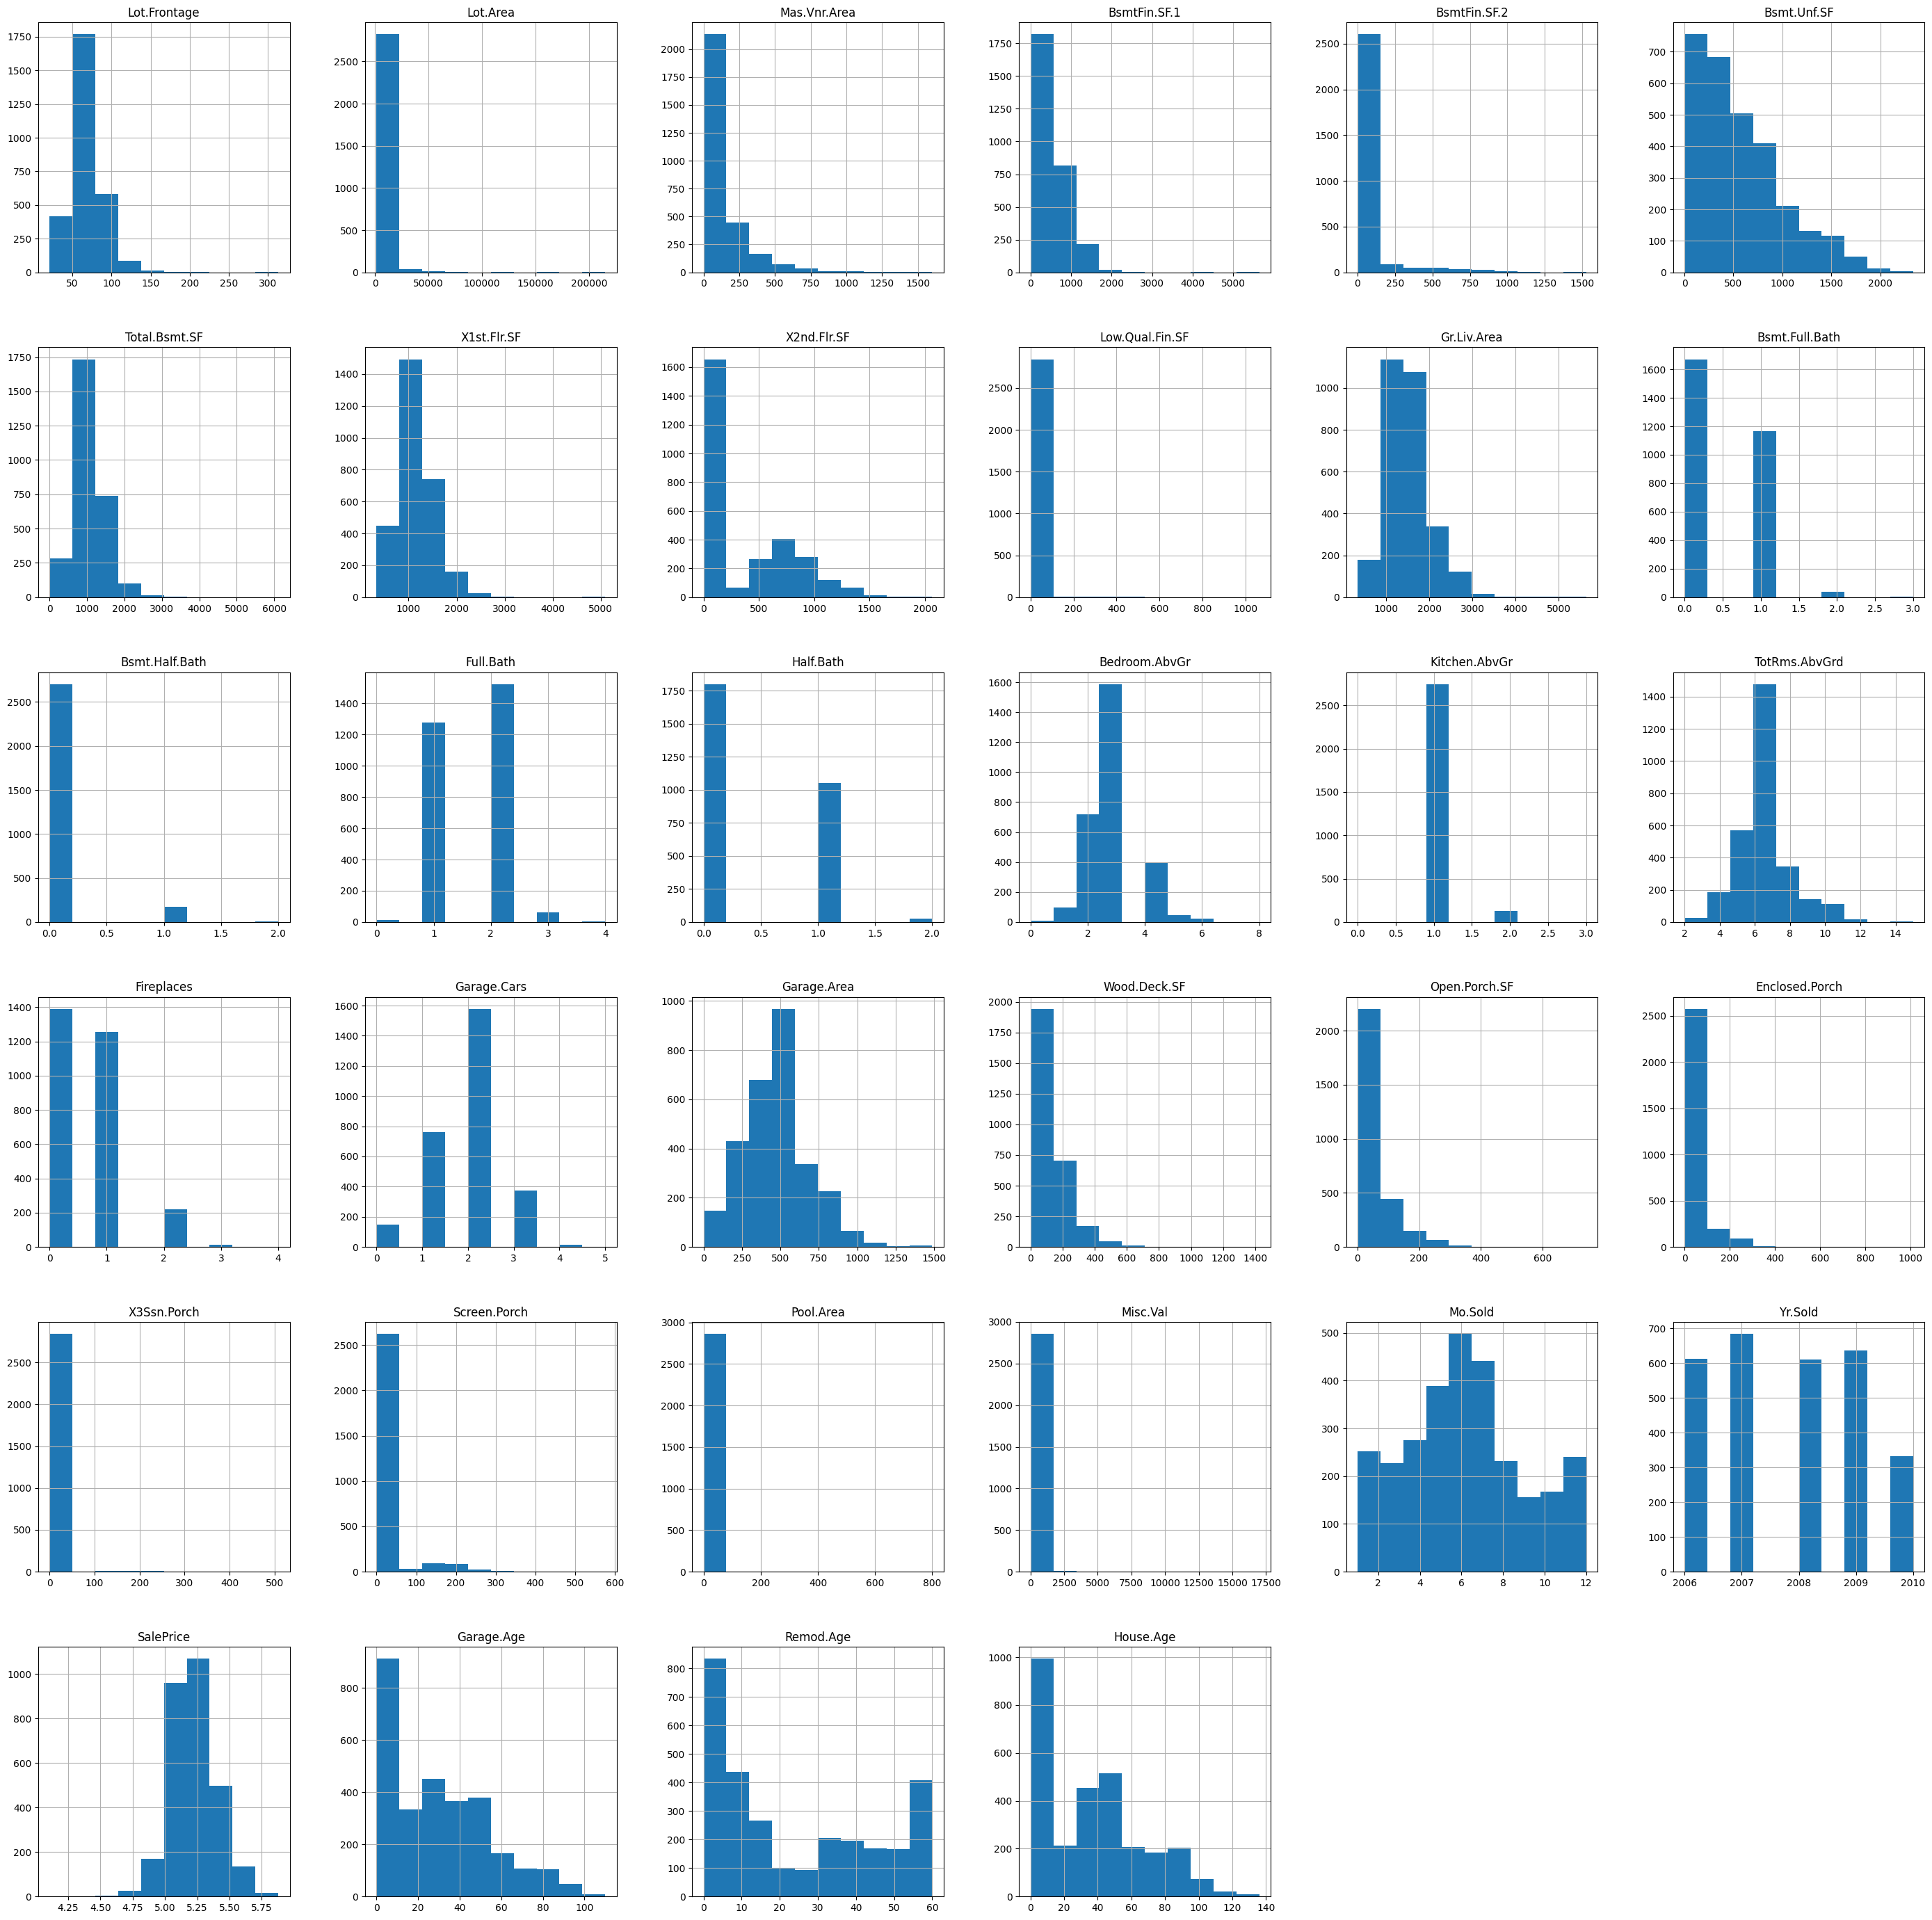

In [468]:
data.hist(figsize=(35,35))
print()

In [469]:
na_list = list(model_data.columns) # inicializando lista que guarda as colunas não analisadas

### Primeiro, checarei variáveis relacionadas ao Lote da casa

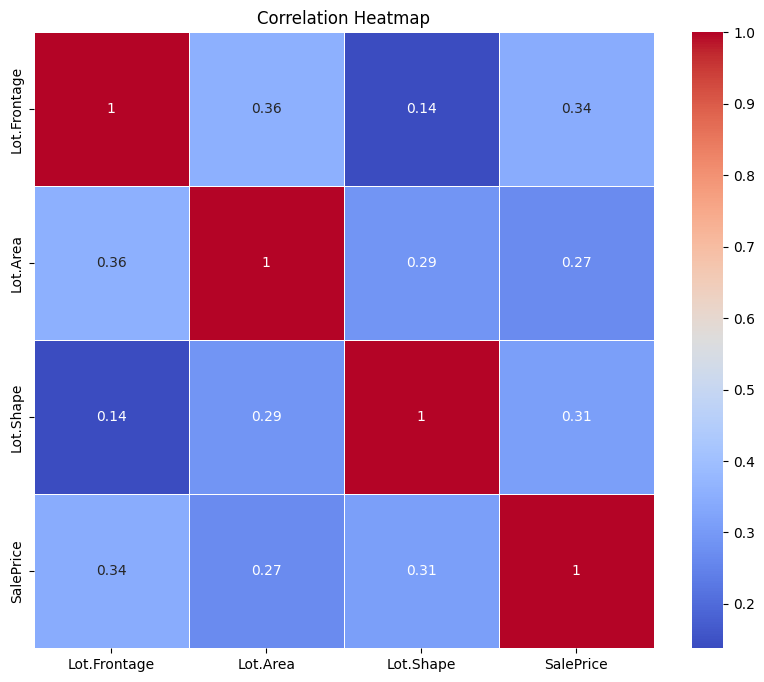

In [470]:
lot_cat = ["Lot.Frontage","Lot.Area","Lot.Shape"]
heatMapCorr(lot_cat)
na_list = [x for x in na_list if x not in lot_cat]

### Todas aparentam ter boa correlação individual com o target, então vamos analisar suas distribuições em busca de melhor representar nossos dados.

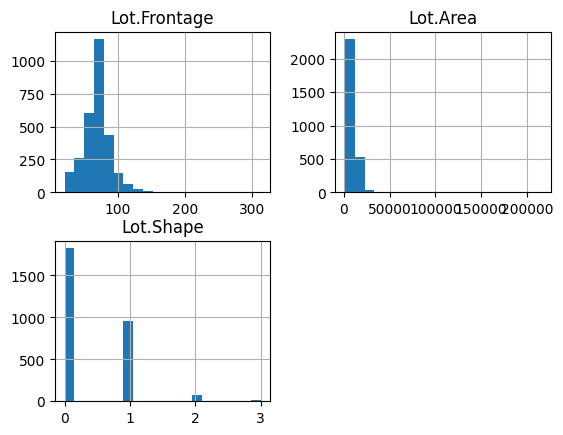

In [471]:
model_data[lot_cat].hist(bins=20)
print()

## Transformação de dados right-skewed em log para melhorar a distribuição dos dados.

Pelo formato do gráfico acima, podemos perceber que os dados de "Lot.Area" tem uma grande quantidade de dados proximos ao zero e conforme a area cresce, a concentração de dados diminui - aplicar uma transformação para log fará nossos dados se tornarem mais legíveis e menos exparsos, mantendo sua propriedade e relevância.

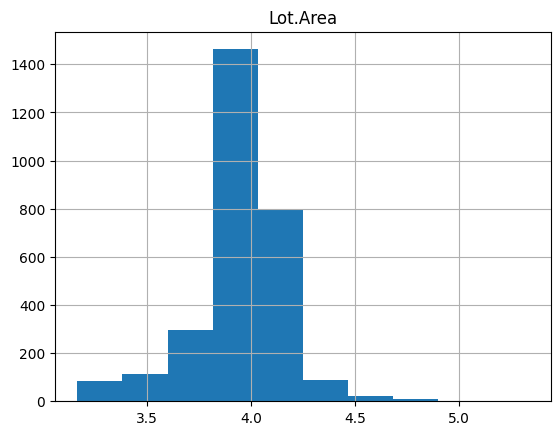

In [472]:
# seems like lot area might use some logs
pd.DataFrame(np.log10(data["Lot.Area"])).hist()
print()

OBS: Daqui para frente, dados com esse formato serão armazenados para serem transformados de uma vez só.

## Mas.Vnr.Area

0.446062177443733
40.25026068821689


/var/folders/4z/6l2f7mfn2sj_wp6mbb6wr0n80000gn/T/ipykernel_95578/451162962.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(model_data[["Mas.Vnr.Area","SalePrice"]].corr()["SalePrice"][0]) # high correlation...


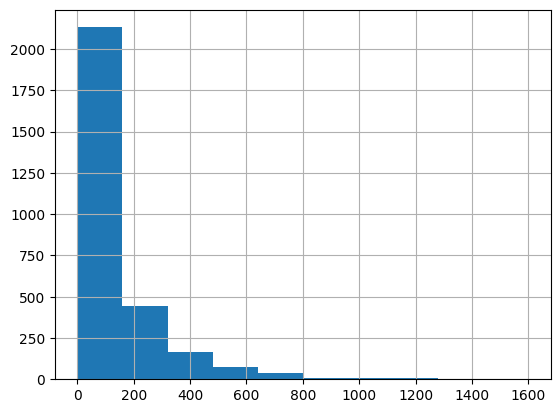

In [473]:
print(model_data[["Mas.Vnr.Area","SalePrice"]].corr()["SalePrice"][0]) # high correlation...
model_data["Mas.Vnr.Area"].hist()
print(nonNull_percent("Mas.Vnr.Area")) # has a good non-null amount...
right_skewed = []
na_list.remove("Mas.Vnr.Area")

Correlação é alta, 40% nonnull, e é right-skewed. Por isso, vamos aplicar log.

In [474]:
right_skewed.append("Mas.Vnr.Area")

## Analysing Exter attributes

Essas features delimitam uma avaliação/ordem crescente e avaliam dados da mesma área, então criar uma feature generalizada pode nos ajudar a remover redundancia dos dados.

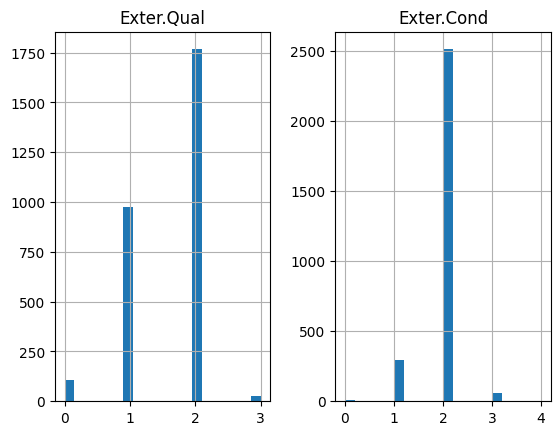

In [475]:
# External features
exter_cat = ["Exter.Qual","Exter.Cond"]
model_data[exter_cat].hist(bins=20) # these seem to reflect a more umbalanced rating
print()
na_list = [x for x in na_list if x not in exter_cat]

Além disso, podemos verificar atráves dos histogramas que a feature criada tem comportamento similar ao de seus componentes e melhora a distribuição dos dados.

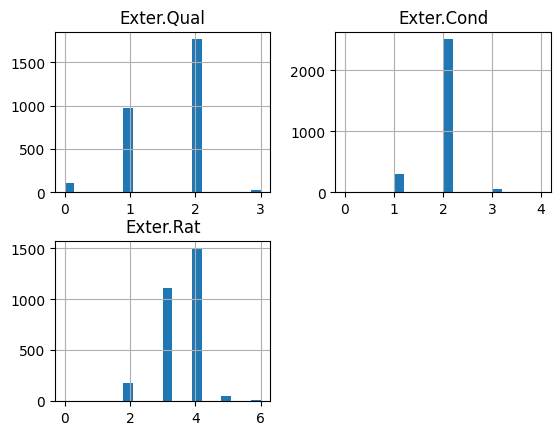

In [476]:
model_data["Exter.Rat"] = model_data["Exter.Qual"] + model_data["Exter.Cond"]
model_data[exter_cat+["Exter.Rat"]].hist(bins=20)
model_data = model_data.drop(columns=exter_cat)

## Dados de Área do Porão

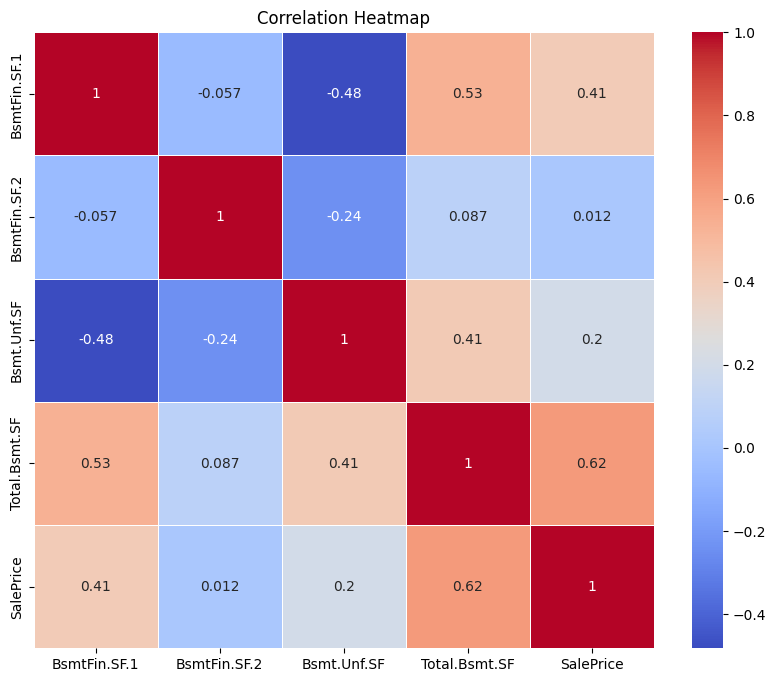

In [477]:
# Basement Features (Area)
basement_cat = ["BsmtFin.SF.1","BsmtFin.SF.2", "Bsmt.Unf.SF","Total.Bsmt.SF"]
heatMapCorr(basement_cat) # checking relevance...
na_list = [x for x in na_list if x not in basement_cat]

BsmtFin.SF.1 68.57838025721237
BsmtFin.SF.2 12.02641640597845
Bsmt.Unf.SF 91.83176920403197
Total.Bsmt.SF 97.46263468891206


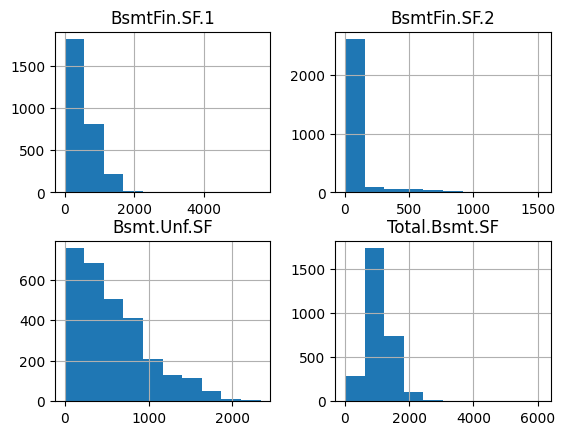

In [478]:
model_data[basement_cat].hist()
for cat in basement_cat:
    print(cat, nonNull_percent(cat))
    
right_skewed += ["BsmtFin.SF.1","BsmtFin.SF.2", "Bsmt.Unf.SF"]

## Feature de Aquecimento e Eletricade

Vericaremos a correlação entre as features e o target para decidir se vale a pena criar uma feature generalizada.

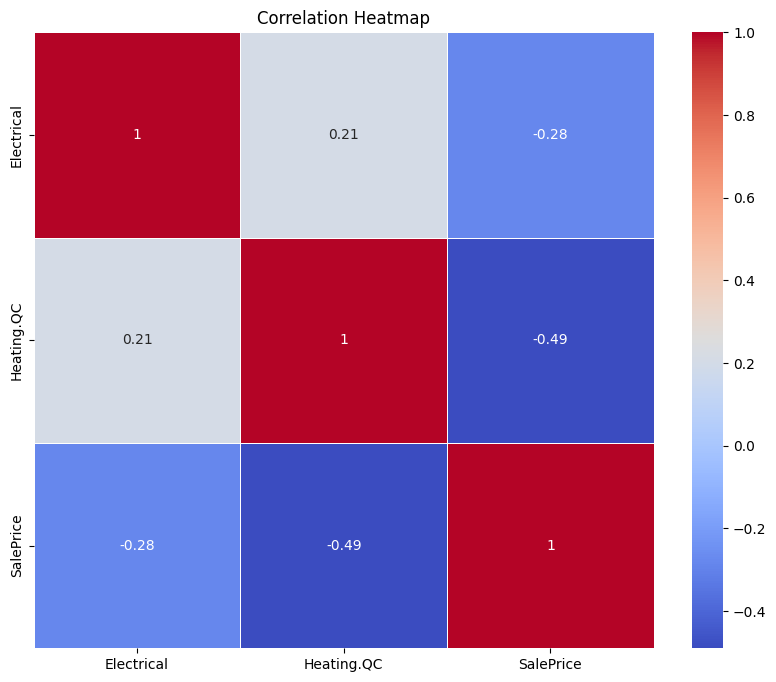

In [479]:
# Heating and Eletrical categories
he_cat = ["Electrical","Heating.QC"]
heatMapCorr(he_cat)  # seems relevant enough
na_list = [x for x in na_list if x not in he_cat]

A correlação entre as features é alta, então não vamos criar uma feature generalizada porque há potencial de perdermos informação.

8.168230795968022
48.348974626346894


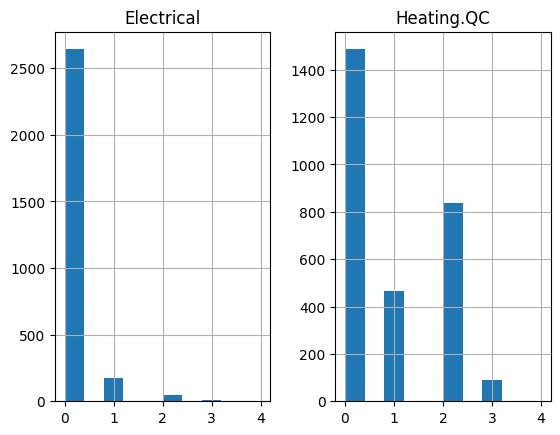

In [480]:
model_data[he_cat].hist()
print(nonNull_percent(he_cat[0]))
print(nonNull_percent(he_cat[1]))

Vimos um non-null percentage de apenas 8.16% para a feature "Electrical", então podemos considerar a remoção dessa feature.

Ao considerar a remoção da feature, devemos analisar a correlação entre as features e o target para decidir se vale a pena. 

Como a correlação é razoavelmente alta(-0.28) para tantos valores comuns, conseguimos interpretar os poucos dados não comuns da feature como dasos relevantes para o target. Portanto, manteremos a feature. 

## Xcat Features

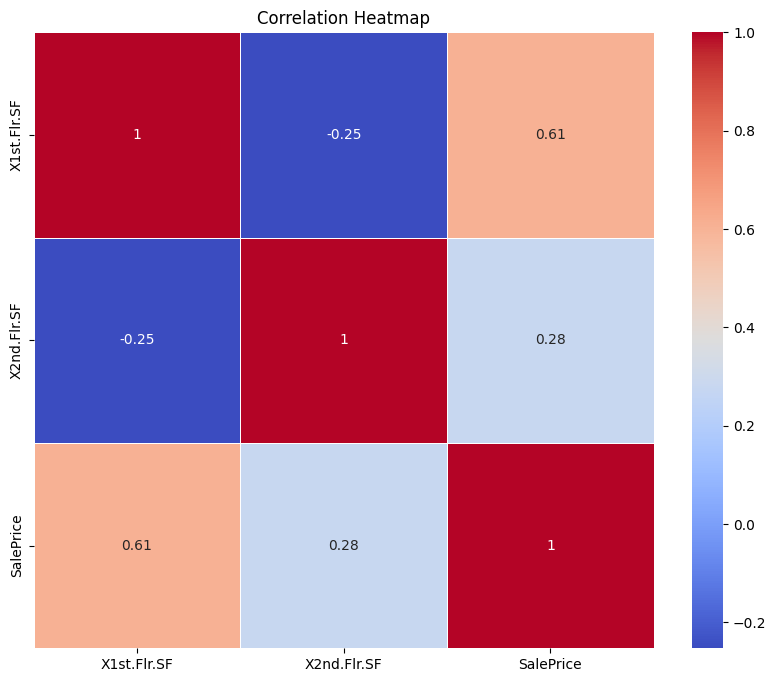

In [481]:
# xcat features
xcat = ["X1st.Flr.SF","X2nd.Flr.SF"] 
heatMapCorr(xcat)
na_list = [x for x in na_list if x not in xcat]

A correlação entre as features é alta, então não vamos criar uma feature generalizada porque há potencial de perdermos informação.

Vamos checar a quantidade de valores não comuns da feature 'X2ndFlrSF' para auxiliar na análise do histograma.

In [482]:
print(nonNull_percent(xcat[1]))

42.75286757038582


Checando os histogramas para decidir se é preciso transformar os dados.

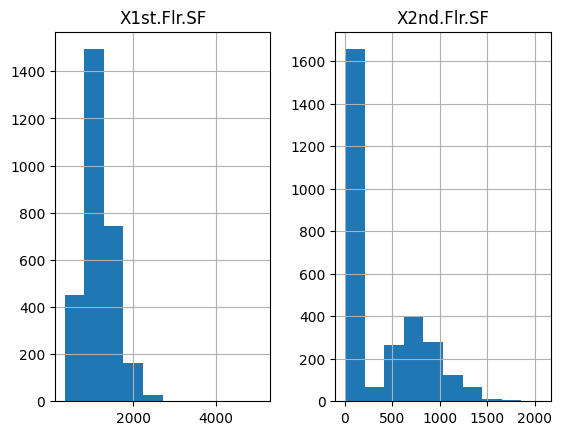

In [483]:
model_data[xcat].hist()
# No worries it seems, still, what is it?
right_skewed.append(xcat[1])

Como X2nd parece ser right-skewed, poderemos transformar os dados em log para melhorar a distribuição dos dados.

## Análise da Feature Low.Qual.Fin.SF

Abaixo estamos verificando a correlação da feature com o target e quantidade de non-null values para ver se vale a pena manter a feature.

In [484]:
print(model_data[["Low.Qual.Fin.SF","SalePrice"]].corr()["SalePrice"][0])
nonNull_percent("Low.Qual.Fin.SF")
na_list.remove("Low.Qual.Fin.SF")

-0.04297306856416149


/var/folders/4z/6l2f7mfn2sj_wp6mbb6wr0n80000gn/T/ipykernel_95578/3901315427.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(model_data[["Low.Qual.Fin.SF","SalePrice"]].corr()["SalePrice"][0])


Como ambos são baixos, removeremos a feature.

In [485]:
model_data = model_data.drop(columns="Low.Qual.Fin.SF")

## Aprimoramento das Features de Cômodos, e Areas Quadradadas de Habitação

Com as informações de "Gr.Liv.Area" e o numero total de quartos, podemos obter o tamanho médio de cada cômodo da casa (SqFtPerRoom), o que será um delimitador importante, visto que pondera varias medidas muito correlatas ao target, podendo ajudar a distiguir entre elas. Essas features serão mantidas.

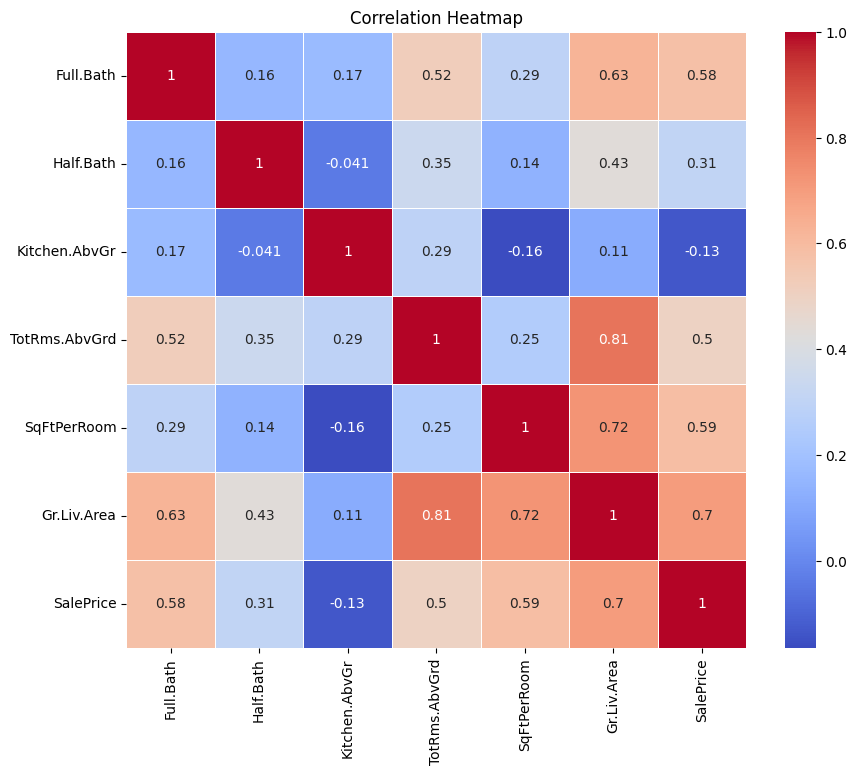

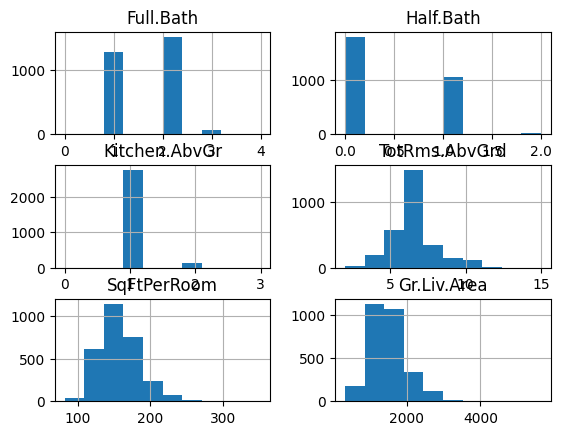

In [486]:
rooms = ["Full.Bath","Half.Bath", "Kitchen.AbvGr", "TotRms.AbvGrd"]
model_data["SqFtPerRoom"] =  model_data["Gr.Liv.Area"] / (model_data["TotRms.AbvGrd"] +
                                                       model_data["Full.Bath"] +
                                                       model_data["Half.Bath"] +
                                                       model_data["Kitchen.AbvGr"])
heatMapCorr(rooms+["SqFtPerRoom","Gr.Liv.Area"])
model_data[rooms + ["SqFtPerRoom","Gr.Liv.Area"]].hist()
print()

na_list = [x for x in na_list if x not in rooms+["SqFtPerRoom","Gr.Liv.Area"]]

## Porch Features

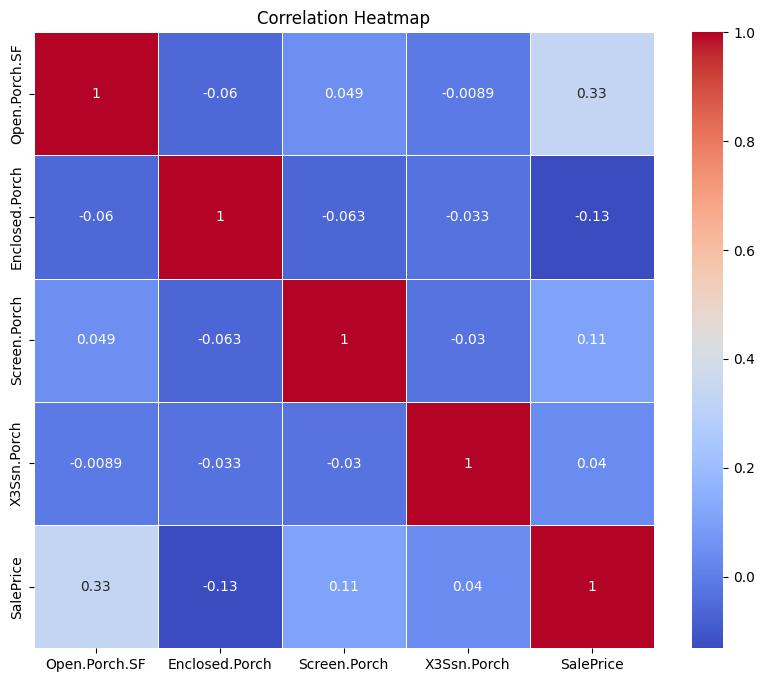

In [487]:
porch_cat = ["Open.Porch.SF","Enclosed.Porch", "Screen.Porch", "X3Ssn.Porch"]
heatMapCorr(porch_cat)
na_list = [x for x in na_list if x not in porch_cat]

Como a correlação é baixa para todos menos o Open.Porch.SF, consideraremos a remoção das features se os non-null values forem baixos também. Também tentaremos fazer uma feature generalizada para ver se conseguimos melhorar a correlação.

In [488]:
model_data['Total.Porch.SF'] = model_data['Open.Porch.SF'] + model_data['Enclosed.Porch'] + model_data['Screen.Porch'] + model_data['X3Ssn.Porch']

Mais uma vez, veremos o heatmap, dessa vez com a feature generalizada para ver se conseguimos melhorar a correlação.

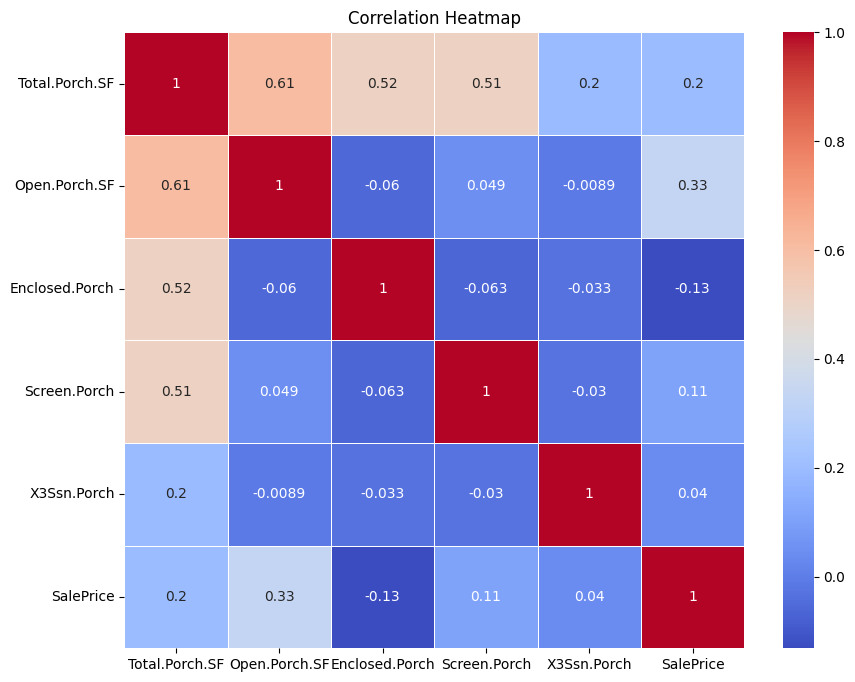

In [489]:
heatMapCorr(['Total.Porch.SF']+porch_cat)

55.89155370177268
15.363225582203684
8.86339937434828
1.251303441084463


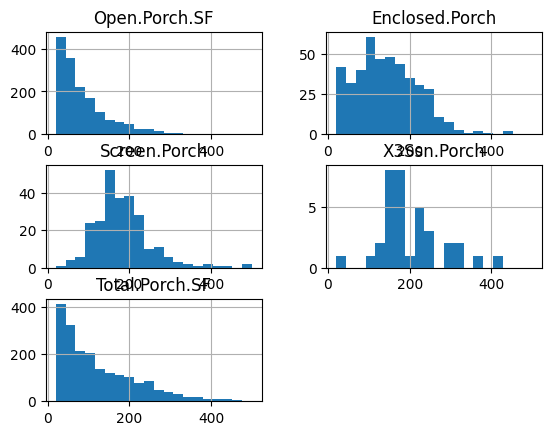

In [490]:
model_data[porch_cat+['Total.Porch.SF']].hist(bins=20,range=(20,500))

for cat in porch_cat:
    print(nonNull_percent(cat))

Como o total porch se parece como o Open.Porch.SF, e é uma combinação de features, apesar de abaixar a correlação um pouco, decidimos manter somente o Total.Porch.SF.

In [491]:
model_data = model_data.drop(columns=porch_cat)

Em cima disso, como Total.Porch.SF é right-skewed, podemos transformar os dados em log para melhorar a distribuição dos dados.

In [492]:
right_skewed.append("Total.Porch.SF")

## Análise de Features que Aparentam ser Redundantes

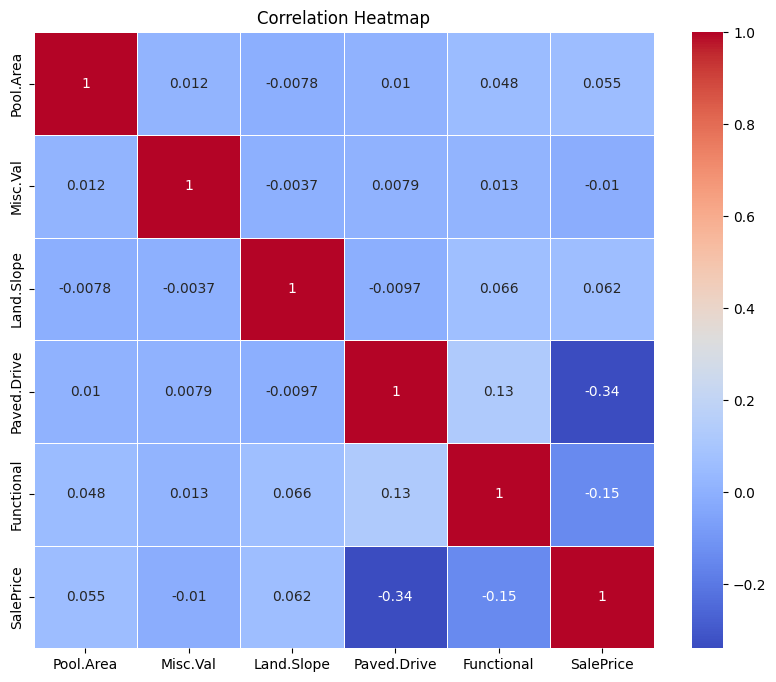

In [493]:
heatMapCorr(["Pool.Area","Misc.Val","Land.Slope","Paved.Drive","Functional"])
na_list = [x for x in na_list if x not in ["Pool.Area","Misc.Val","Land.Slope","Paved.Drive","Functional"]]

Como quase todas as features tem baixíssima correlação, removeremos todas menos os "Paved.Drive" e "Functional", que analisaremos mais a fundo.

In [494]:
model_data = model_data.drop(columns=["Pool.Area","Misc.Val","Land.Slope"])

# Agora analisando as colunas que sobraram
print(nonNull_percent("Paved.Drive"))
print(nonNull_percent("Functional"))

8.932916232186304
6.777893639207508


Como a correlação é considerável, e a quantidade de non-null values é baixa, esses non-null values podem ser considerados como dados relevantes para o target. Portanto, manteremos as features.

## Overall Quality and Condition

### Unificação de Avaliação

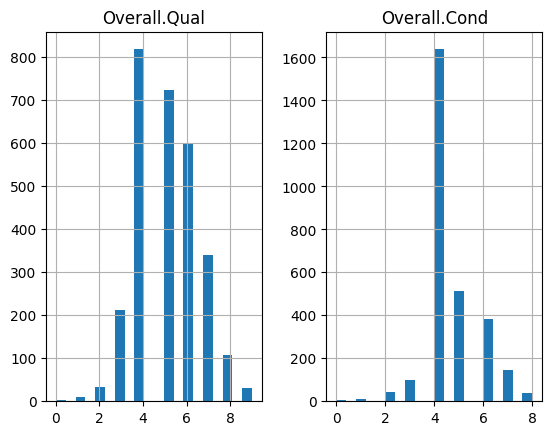

In [495]:
# Overall Quality and Condition
overall_cat = ["Overall.Qual","Overall.Cond"]
model_data[overall_cat].hist(bins=20) # these seem to reflect a more umbalanced rating
print()
na_list = [x for x in na_list if x not in overall_cat]

array([[<Axes: title={'center': 'Overall.Qual'}>,
        <Axes: title={'center': 'Overall.Cond'}>],
       [<Axes: title={'center': 'Overall.Rat'}>, <Axes: >]], dtype=object)

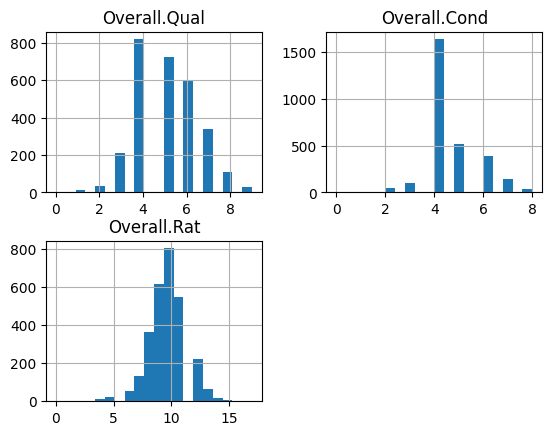

In [496]:
model_data["Overall.Rat"] = model_data["Overall.Qual"] + model_data["Overall.Cond"]
model_data[overall_cat+["Overall.Rat"]].hist(bins=20)

In [497]:
model_data = model_data.drop(columns=overall_cat)

## Verificando Features que Ainda Não Foram Analisadas

array([[<Axes: title={'center': 'Bsmt.Full.Bath'}>,
        <Axes: title={'center': 'Bsmt.Half.Bath'}>,
        <Axes: title={'center': 'Bedroom.AbvGr'}>,
        <Axes: title={'center': 'Kitchen.Qual'}>],
       [<Axes: title={'center': 'Fireplaces'}>,
        <Axes: title={'center': 'Garage.Cars'}>,
        <Axes: title={'center': 'Garage.Area'}>,
        <Axes: title={'center': 'Wood.Deck.SF'}>],
       [<Axes: title={'center': 'Fence'}>,
        <Axes: title={'center': 'Mo.Sold'}>,
        <Axes: title={'center': 'Yr.Sold'}>,
        <Axes: title={'center': 'SalePrice'}>],
       [<Axes: title={'center': 'Garage.Age'}>,
        <Axes: title={'center': 'Remod.Age'}>,
        <Axes: title={'center': 'House.Age'}>, <Axes: >]], dtype=object)

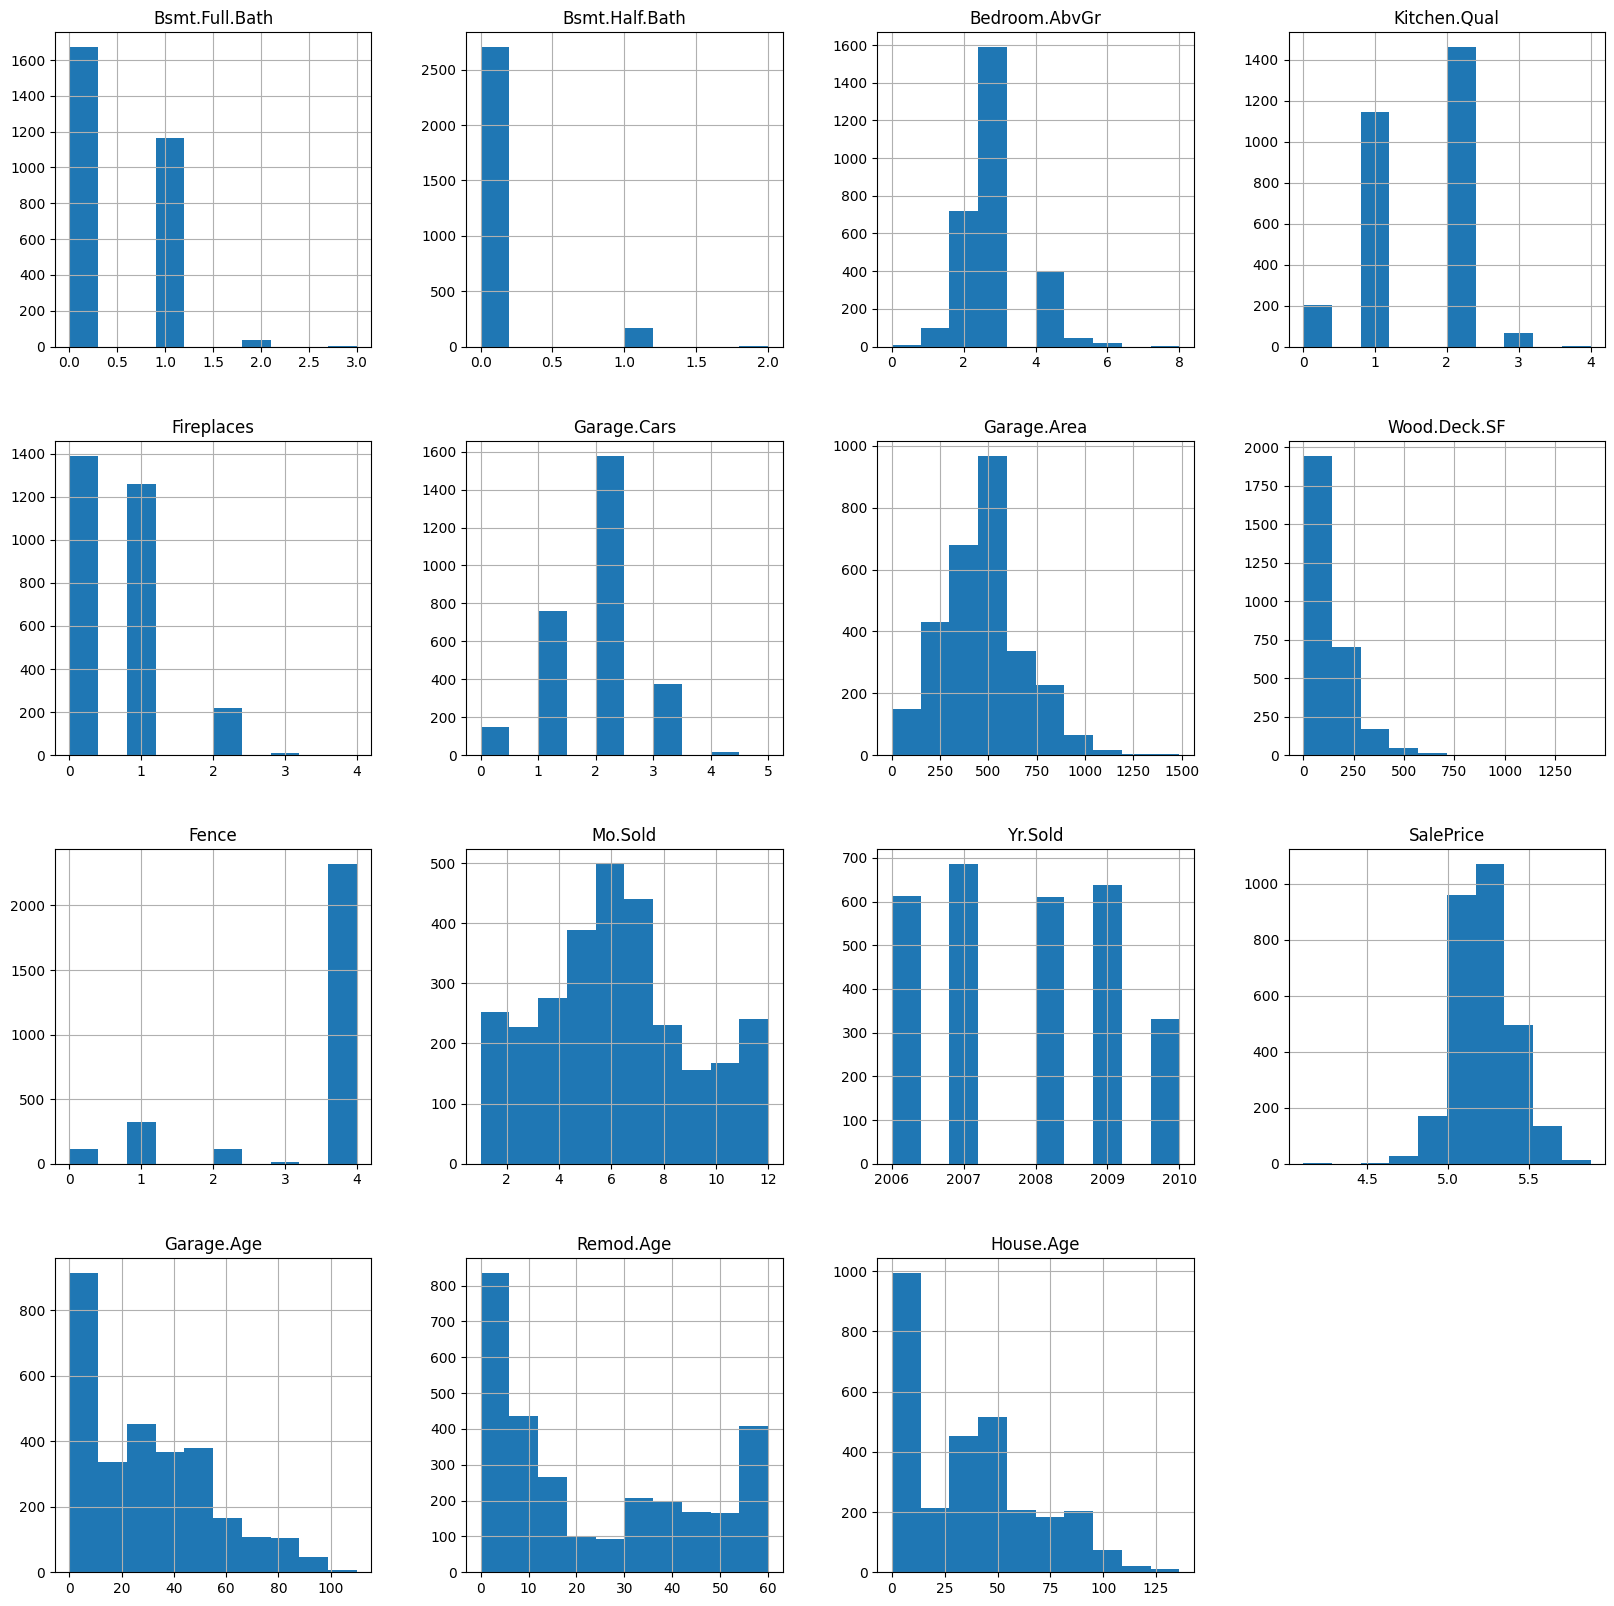

In [498]:
model_data[na_list].hist(figsize=(20,20))

## Features de Garagem

array([[<Axes: title={'center': 'Garage.Cars'}>,
        <Axes: title={'center': 'Garage.Area'}>]], dtype=object)

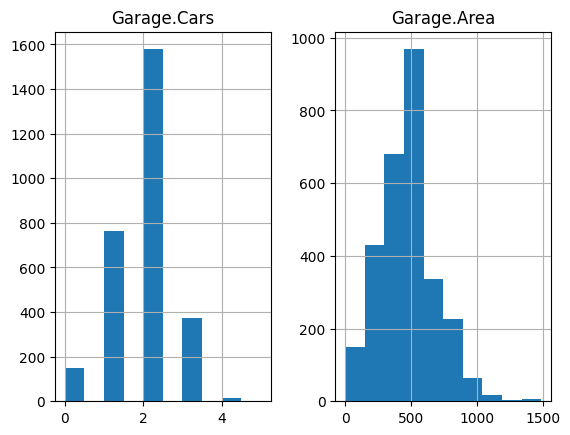

In [499]:
gar_cat = ["Garage.Cars","Garage.Area"]
model_data[gar_cat].hist(bins=10)

Como são parecidos, vamos tentar criar uma feature generalizada.

<Axes: >

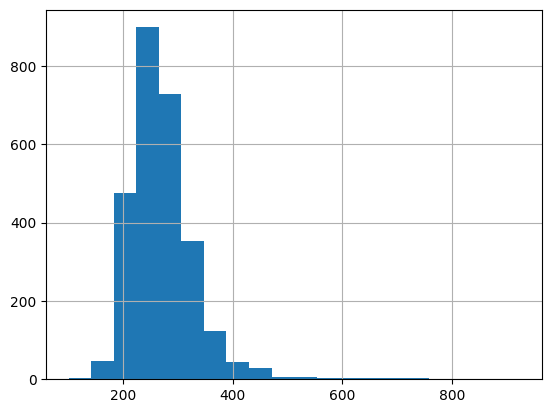

In [500]:
model_data["FtPerCar"] = model_data["Garage.Area"] / model_data["Garage.Cars"]
model_data["FtPerCar"].hist(bins=20)

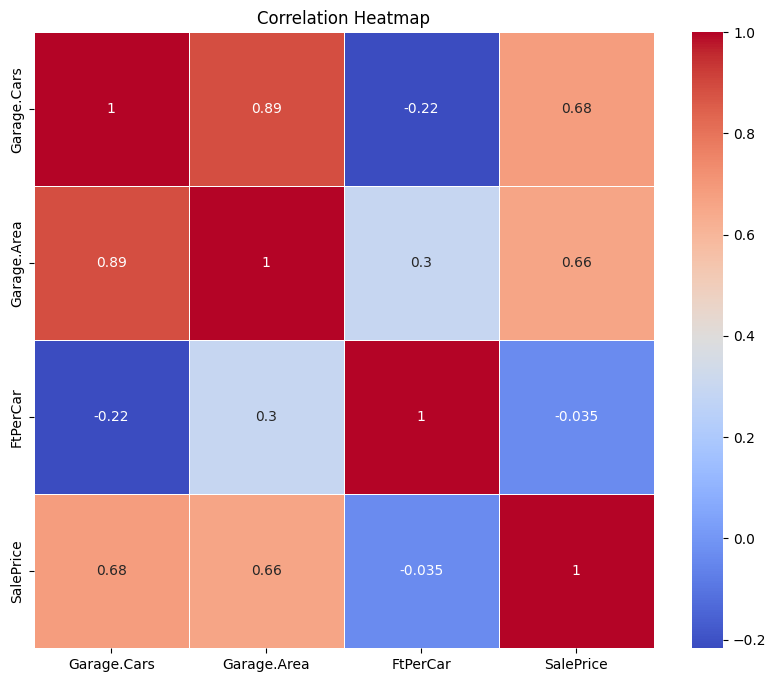

In [501]:
heatMapCorr(gar_cat + ["FtPerCar"])
na_list = [x for x in na_list if x not in gar_cat]

Como a correlação de "Garage.Cars" e "Garage.Area" é alta, e a de "FtPerCar" é baixa, vamos remover "FtPerCar", e manter as outras duas.

In [502]:
model_data = model_data.drop(columns=["FtPerCar"])
print()

## Features Restantes da Casa

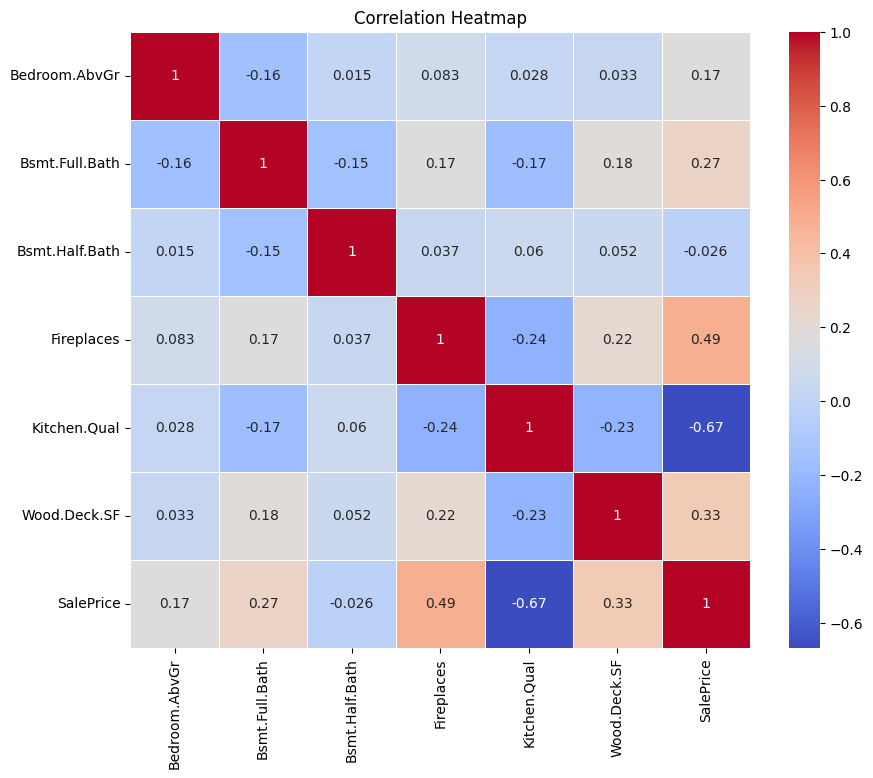

In [503]:
restantes = ["Bedroom.AbvGr","Bsmt.Full.Bath","Bsmt.Half.Bath", "Fireplaces", "Kitchen.Qual","Wood.Deck.SF"]
heatMapCorr(restantes)

Como o Bsmt.Half.Bath tem uma correlação baixa, e o Bsmt.Full.Bath tem uma correlação alta, vamos tentar combinar o Bsmt.Half.Bath com o Bsmt.Full.Bath para criar uma feature generalizada.

In [504]:
model_data['Bsmt.Total.Baths'] = model_data['Bsmt.Full.Bath'] + model_data['Bsmt.Half.Bath']

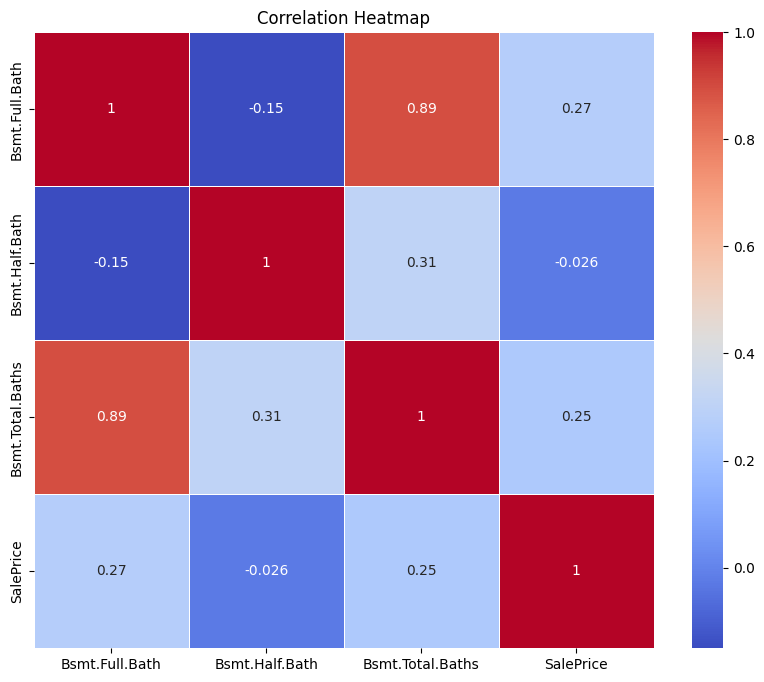

In [505]:
heatMapCorr(['Bsmt.Full.Bath', 'Bsmt.Half.Bath','Bsmt.Total.Baths'])

Ficando somente com o Bsmt.Total.Baths, perdemos pouca correlação, e ganhamos uma feature generalizada.

In [506]:
model_data = model_data.drop(columns=['Bsmt.Full.Bath', 'Bsmt.Half.Bath'])
print()

array([[<Axes: title={'center': 'Mas.Vnr.Area'}>,
        <Axes: title={'center': 'BsmtFin.SF.1'}>],
       [<Axes: title={'center': 'BsmtFin.SF.2'}>,
        <Axes: title={'center': 'Bsmt.Unf.SF'}>],
       [<Axes: title={'center': 'X2nd.Flr.SF'}>,
        <Axes: title={'center': 'Total.Porch.SF'}>]], dtype=object)

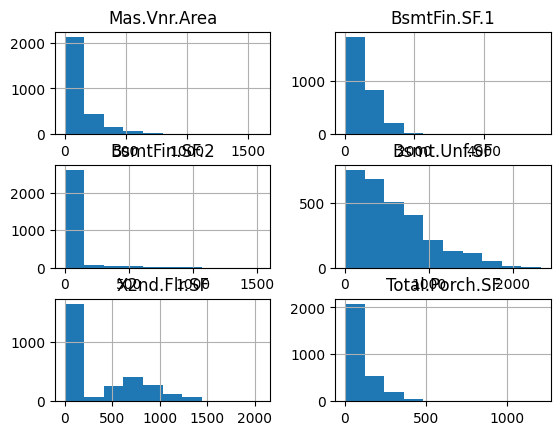

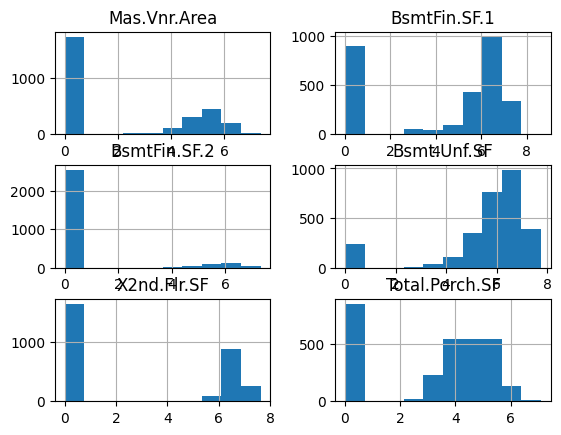

In [507]:
model_data[right_skewed].hist()
model_data[right_skewed] = np.log1p(model_data[right_skewed])
model_data[right_skewed].hist()

In [508]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [509]:
y = model_data["SalePrice"].copy()
X = model_data.drop(columns=["SalePrice"]).copy()
        
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25,random_state=12,)
error_percent = {"LinearRegression":0,"Ridge":0,"Lasso":0}

In [510]:
piped_linear = Pipeline([
    ("Polynomial",PolynomialFeatures()),
    ("Scaler", StandardScaler()),
    ("Linear", LinearRegression()),
])

param_grid_linear = {
    'Polynomial__degree': [0,1,2],
}

grid_search_linear = GridSearchCV(piped_linear, param_grid_linear, 
                              cv=5, scoring="neg_mean_squared_error")

grid_search_linear.fit(Xtrain,ytrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Polynomial', PolynomialFeatures()),
                                       ('Scaler', StandardScaler()),
                                       ('Linear', LinearRegression())]),
             param_grid={'Polynomial__degree': [0, 1, 2]},
             scoring='neg_mean_squared_error')

In [511]:
print(f'melhores parametros para Linear Regression: {grid_search_linear.best_params_}')
score_linear = cross_val_score(grid_search_linear.best_estimator_,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_linear = np.sqrt(-score_linear)
print(f'RMSE: {list(score_linear)}')
error_percent_linear = 100 * (10**score_linear - 1)

error_percent["LinearRegression"] = error_percent_linear
print(f'erro percentual: {list(error_percent["LinearRegression"])}')

melhores parametros para Linear Regression: {'Polynomial__degree': 0}
RMSE: [0.165713118458037, 0.18035322296263231, 0.17169509155849005, 0.1707859092467859, 0.17962224099284665]
erro percentual: [46.45800649234633, 51.479276778899454, 48.489276624255375, 48.178743990843806, 51.224529157979305]


In [512]:
piped_ridge = Pipeline([
    ("Polynomial",PolynomialFeatures()),
    ("Scaler", StandardScaler()),
    ("Ridge", Ridge())
])

param_grid_ridge = {
    'Ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'Polynomial__degree': [0,1,2],
}

grid_search_ridge = GridSearchCV(piped_ridge, param_grid_ridge, 
                              cv=5, scoring="neg_mean_squared_error")

grid_search_ridge.fit(Xtrain,ytrain)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Polynomial', PolynomialFeatures()),
                                       ('Scaler', StandardScaler()),
                                       ('Ridge', Ridge())]),
             param_grid={'Polynomial__degree': [0, 1, 2],
                         'Ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]},
             scoring='neg_mean_squared_error')

In [513]:
print(f'melhores parametros para Ridge Regression: {grid_search_ridge.best_params_}')
score_ridge = cross_val_score(grid_search_ridge.best_estimator_,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_ridge = np.sqrt(-score_ridge)
print(f'RMSE: {list(score_ridge)}')
error_percent_ridge = 100 * (10**score_ridge - 1)
error_percent["Ridge"] = error_percent_ridge
print(f'erro percentual: {list(error_percent["Ridge"])}')

melhores parametros para Ridge Regression: {'Polynomial__degree': 1, 'Ridge__alpha': 10.0}
RMSE: [0.046393325939765834, 0.055688596483162336, 0.057256689467549915, 0.051694291753605785, 0.053530800367690534]
erro percentual: [11.273904147997316, 13.681186178678463, 14.092393065355257, 12.640427938544118, 13.117761013396345]


In [514]:
piped_lasso = Pipeline([
    ("Polynomial",PolynomialFeatures()),
    ("Scaler", StandardScaler()),
    ("Lasso", Lasso())
])

param_grid_lasso = {
    'Lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'Polynomial__degree': [0,1,2],
}

grid_search_lasso = GridSearchCV(piped_lasso, param_grid_lasso, 
                              cv=5, scoring="neg_mean_squared_error")

grid_search_lasso.fit(Xtrain,ytrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Polynomial', PolynomialFeatures()),
                                       ('Scaler', StandardScaler()),
                                       ('Lasso', Lasso())]),
             param_grid={'Lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'Polynomial__degree': [0, 1, 2]},
             scoring='neg_mean_squared_error')

In [515]:
print(f'melhores parametros para Lasso Regression: {grid_search_lasso.best_params_}')
score_lasso = cross_val_score(grid_search_lasso.best_estimator_,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_lasso = np.sqrt(-score_lasso)
print(f'RMSE: {list(score_lasso)}')
error_percent_lasso = 100 * (10**score_lasso - 1)
error_percent["Lasso"] = error_percent_lasso
print(f'erro percentual: {list(error_percent["Lasso"])}')

melhores parametros para Lasso Regression: {'Lasso__alpha': 0.001, 'Polynomial__degree': 1}
RMSE: [0.04513380810698615, 0.05686016318671184, 0.058994035712525116, 0.048404541292128546, 0.054700996909769685]
erro percentual: [10.951660972397725, 13.98827020100648, 14.549720990424309, 11.790408025114395, 13.422965229830218]


In [516]:
from scipy.stats import ttest_ind



ttest_ind(error_percent_ridge, error_percent_lasso, equal_var=False)

TtestResult(statistic=0.02456299830396619, pvalue=0.981064185549132, df=7.270302878963496)

In [517]:
import xgboost as xgb

# Os melhores parametros do XGB foram obtidos com o GridSearchCV no notebook 06_xgboost_regression_modeling.ipynb
XGB = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=150, reg_alpha=0, reg_lambda=1, subsample=0.7, seed=42)

XGB.fit(Xtrain,ytrain)

/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [518]:
score_xgb = cross_val_score(XGB,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_xgb = np.sqrt(-score_xgb)
print(f'RMSE: {list(score_xgb)}')
error_percent_xgb = 100 * (10**score_xgb - 1)
error_percent["XGBoost"] = error_percent_xgb
print(f'erro percentual: {list(error_percent["XGBoost"])}')

/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/

RMSE: [0.04669668781131245, 0.052592840267507754, 0.049153908390312834, 0.050692535038024816, 0.05964699066953876]
erro percentual: [11.351657961646634, 12.873720484371809, 11.983466818886823, 12.380907563043376, 14.722074236015171]


/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/femcdias/Documents/Insper/Semestre 4/Machine Learning/Projeto1/ames/env/

In [519]:
import catboost as cb

# Os melhores parametros do CatBoost foram obtidos com o GridSearchCV no notebook 07_catboost_regression_modeling.ipynb
CB = cb.CatBoostRegressor(bagging_temperature=0, border_count=32, depth=6, iterations=4000, l2_leaf_reg=0.75, learning_rate=0.05, model_size_reg=0.5, od_wait=100, random_seed=42, random_strength=3)

CB.fit(Xtrain,ytrain)


0:	learn: 0.1686270	total: 6.93ms	remaining: 27.7s
1:	learn: 0.1631006	total: 10.7ms	remaining: 21.5s
2:	learn: 0.1583999	total: 12.8ms	remaining: 17.1s
3:	learn: 0.1536775	total: 15ms	remaining: 15s
4:	learn: 0.1493384	total: 17.2ms	remaining: 13.7s
5:	learn: 0.1445049	total: 20.2ms	remaining: 13.5s
6:	learn: 0.1406853	total: 22.1ms	remaining: 12.6s
7:	learn: 0.1368160	total: 24.1ms	remaining: 12s
8:	learn: 0.1331524	total: 26.2ms	remaining: 11.6s
9:	learn: 0.1294221	total: 28.3ms	remaining: 11.3s
10:	learn: 0.1261864	total: 30.2ms	remaining: 11s
11:	learn: 0.1228301	total: 32.2ms	remaining: 10.7s
12:	learn: 0.1197607	total: 35.5ms	remaining: 10.9s
13:	learn: 0.1168440	total: 37.7ms	remaining: 10.7s
14:	learn: 0.1134857	total: 40.5ms	remaining: 10.8s
15:	learn: 0.1107294	total: 42.5ms	remaining: 10.6s
16:	learn: 0.1082717	total: 44.4ms	remaining: 10.4s
17:	learn: 0.1056456	total: 46.6ms	remaining: 10.3s
18:	learn: 0.1031583	total: 48.5ms	remaining: 10.2s
19:	learn: 0.1006524	total: 50

In [520]:
score_cb = cross_val_score(CB,Xtrain,ytrain, scoring="neg_mean_squared_error")
score_cb = np.sqrt(-score_cb)
print(f'RMSE: {list(score_cb)}')
error_percent_cb = 100 * (10**score_cb - 1)
error_percent["CatBoost"] = error_percent_cb
print(f'erro percentual: {list(error_percent["CatBoost"])}')

0:	learn: 0.1698216	total: 2.18ms	remaining: 8.7s
1:	learn: 0.1646588	total: 4ms	remaining: 8s
2:	learn: 0.1592881	total: 6.25ms	remaining: 8.33s
3:	learn: 0.1545392	total: 7.93ms	remaining: 7.92s
4:	learn: 0.1497516	total: 9.59ms	remaining: 7.66s
5:	learn: 0.1455508	total: 11.3ms	remaining: 7.54s
6:	learn: 0.1411599	total: 13ms	remaining: 7.42s
7:	learn: 0.1370009	total: 14.8ms	remaining: 7.39s
8:	learn: 0.1331989	total: 17.6ms	remaining: 7.8s
9:	learn: 0.1296626	total: 19.4ms	remaining: 7.72s
10:	learn: 0.1262949	total: 21.6ms	remaining: 7.82s
11:	learn: 0.1228305	total: 24ms	remaining: 7.97s
12:	learn: 0.1193508	total: 26.1ms	remaining: 7.99s
13:	learn: 0.1162231	total: 27.9ms	remaining: 7.95s
14:	learn: 0.1133518	total: 29.7ms	remaining: 7.9s
15:	learn: 0.1103918	total: 31.6ms	remaining: 7.87s
16:	learn: 0.1073367	total: 33.5ms	remaining: 7.84s
17:	learn: 0.1050687	total: 35.2ms	remaining: 7.78s
18:	learn: 0.1024477	total: 36.9ms	remaining: 7.74s
19:	learn: 0.1001012	total: 38.8ms	

In [521]:
# Ttest
from scipy.stats import ttest_ind
saved = []
for key in list(error_percent.keys()):
    for key2 in list(error_percent.keys()):
        if key2 != key and (key2,key) not in saved: 
            saved.append((key,key2))
            print(f'{key} vs {key2}')
            r = ttest_ind(error_percent[key],error_percent[key2],equal_var=False)
            print(r,'\n')

LinearRegression vs Ridge
TtestResult(statistic=33.66835355594331, pvalue=5.121610220120919e-08, df=5.948345981588104) 

LinearRegression vs Lasso
TtestResult(statistic=30.863349123318063, pvalue=6.4018843658785015e-09, df=7.204397470884455) 

LinearRegression vs XGBoost
TtestResult(statistic=32.71544316055937, pvalue=1.7330580179722786e-08, df=6.53091861465831) 

LinearRegression vs CatBoost
TtestResult(statistic=34.09162655921919, pvalue=2.696467908893531e-08, df=6.20547359842108) 

Ridge vs Lasso
TtestResult(statistic=0.02456299830396619, pvalue=0.981064185549132, df=7.270302878963496) 

Ridge vs XGBoost
TtestResult(statistic=0.3971690437036601, pvalue=0.701877589749903, df=7.8084072261621404) 

Ridge vs CatBoost
TtestResult(statistic=1.4512066550346936, pvalue=0.18497116147025183, df=7.9582869884260825) 

Lasso vs XGBoost
TtestResult(statistic=0.313605041868859, pvalue=0.7620647674390439, df=7.779060373840403) 

Lasso vs CatBoost
TtestResult(statistic=1.1895658206334185, pvalue=0.2

In [522]:
# Best model
best_model = ''
best_average = 100
for key in error_percent.keys():
    print(f'{key} error percentual: {error_percent[key].mean()}')
    if error_percent[key].mean() < best_average:
        best_average = error_percent[key].mean()
        best_model = key
print(f'Best model: {best_model}')


LinearRegression error percentual: 49.16596660886485
Ridge error percentual: 12.961134468794302
Lasso error percentual: 12.940605083754624
XGBoost error percentual: 12.662365412792763
CatBoost error percentual: 11.920221073552145
Best model: CatBoost
